In [31]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend("matplotlib")

from pfs.drp.stella import SpectrumSet
from pfs.drp.stella.subtractSky1d import subtractSky1d
from pfs.drp.stella.utils import showDetectorMap
from pfs.drp.stella.utils import addPfsCursor

from pfs.utils.fiberids import FiberIds
from pfs.datamodel import PfsDesign, FiberStatus, TargetType
from scipy.stats import iqr

In [32]:
repoDir='/work/drp'
pfsDesignDir = '/work/drp/pfsDesign'
rerun = os.path.join(repoDir, 'rerun', f'pfs/internal/edr2-20231106-qa')
calibRoot = os.path.join(repoDir, 'CALIB')
butler = dafPersist.Butler(rerun, calibRoot=calibRoot)

lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3


/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.45/python/pfs/drp/stella/utils/display.py:243: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


(1900.0, 2100.0)

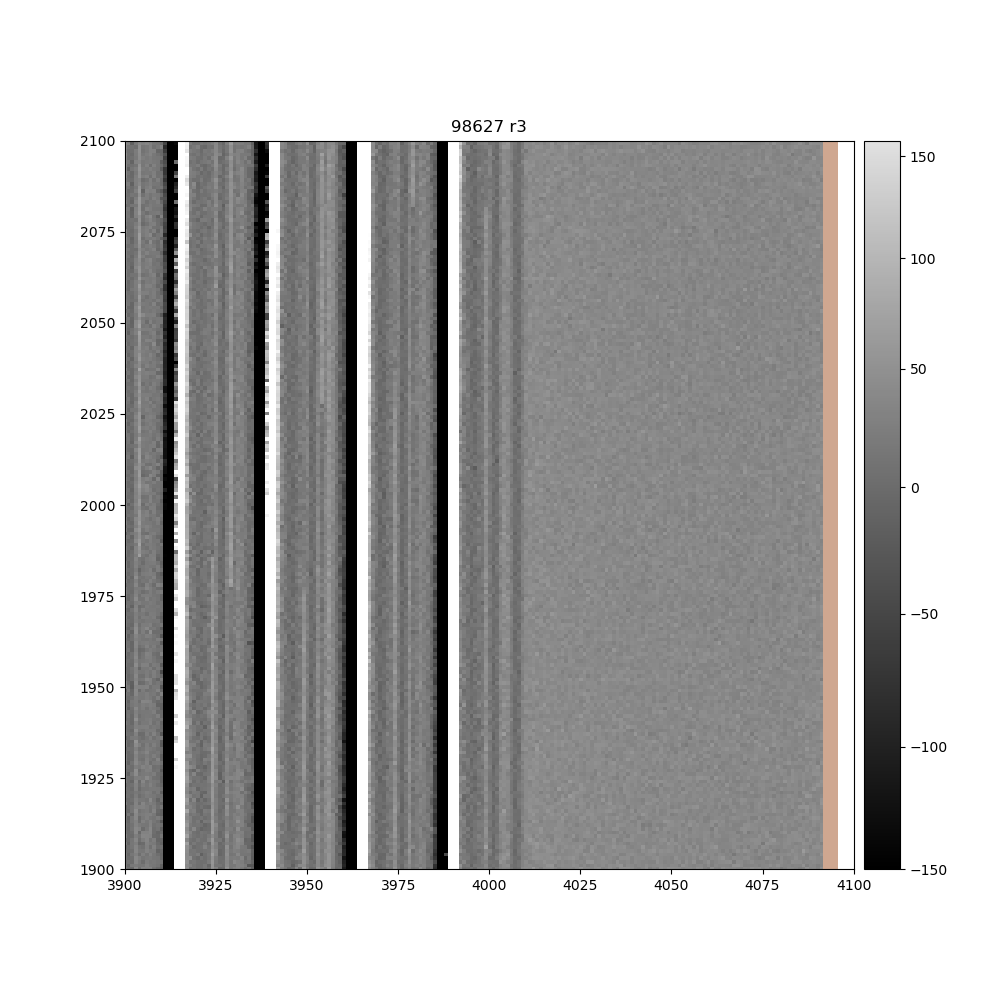

In [66]:
visit = 98627
spectrograph=3
arm='r'
dataId=dict(visit=visit, spectrograph=spectrograph, arm=arm)

pfsConfig = butler.get('pfsConfig', dataId)
calexp = butler.get('calexp', dataId)
detMap = butler.get('detectorMap_used', dataId)
profiles = butler.get("fiberProfiles", dataId)
pfsArm = butler.get("pfsArm", dataId)

spectra = SpectrumSet.fromPfsArm(pfsArm)
traces = profiles.makeFiberTracesFromDetectorMap(detMap)
image = spectra.makeImage(calexp.getDimensions(), traces)

subtracted = calexp.clone()
subtracted.image -= image

fig = 1; plt.close(fig); plt.figure(fig, figsize=(10,10))
disp = afwDisplay.Display(fig)
#disp.scale('asinh', -50, 100, Q=2)
disp.scale('asinh', 'zscale', Q=1)
disp.setMaskPlaneColor("REFLINE", afwDisplay.IGNORE)
disp.mtv(subtracted, title=f"{'%(visit)d %(arm)s%(spectrograph)d' % dataId}")
addPfsCursor(disp, detMap)
plt.xlim(3900,4100)
plt.ylim(1900, 2100)

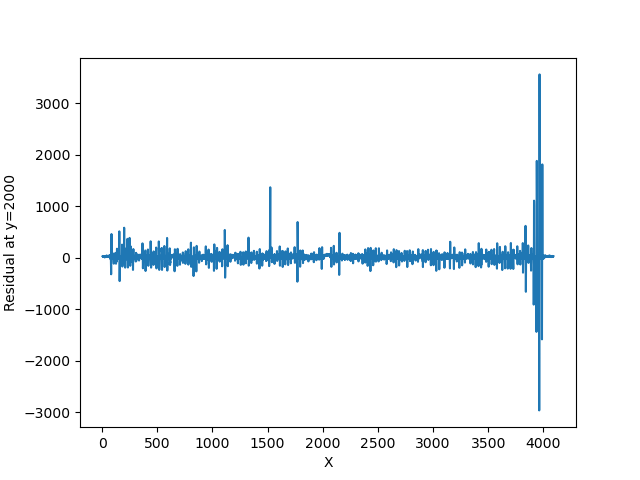

In [65]:
fig =3; plt.close(fig)
fig = plt.figure()
plt.plot(subtracted.image.array[2000,:])
plt.xlabel('X')
plt.ylabel('Residual at y=2000')
plt.show()

In [60]:
from scipy.optimize import curve_fit
def gaussian_func(x, a,  mu, sigma):
    return a * np.exp( - (x - mu)**2 / (2 * sigma**2))

msk = (pfsConfig.spectrograph == spectrograph) * (pfsConfig.fiberStatus == FiberStatus.GOOD)
fiberIds = pfsConfig[msk].fiberId
xarray = []
yarray = []
dxarray = []
dwarray = []
ymin = 0
ymax = calexp.getDimensions()[1]
yo = np.arange(ymin, ymax).astype(np.float64)
xwidth = 5
failNum = 0
centerdif = []
widthdif = []
for fiberId in fiberIds:
    xo = detMap.getXCenter(fiberId, yo)
    ys = np.arange(ymin, ymax, (ymax-ymin)/200).astype("int32")
    xint = xo.astype("int32")
    pfsArmAve = np.average(pfsArm[pfsArm.fiberId==fiberId].flux[0])
    if pfsArmAve > 0:
        for j in range(200):
            yfit = ys[j]
            xfit = xint[yfit]
            xcoordNarrow = np.arange(xfit - xwidth, xfit + xwidth + 1)
            pfsArmCutNarrow = image.array[yfit, xfit - xwidth:xfit + xwidth + 1]
            calExpCutNarrow = calexp.image.array[yfit, xfit - xwidth:xfit + xwidth + 1]
            try:
                poptPfsArm, pcovPfsArm = curve_fit(gaussian_func, xcoordNarrow, pfsArmCutNarrow,
                                                   p0=np.array([np.max(pfsArmCutNarrow), np.median(xcoordNarrow),
                                                               1.]))
                poptCalExp, pcovCalExp = curve_fit(gaussian_func, xcoordNarrow, calExpCutNarrow,
                                                   p0=np.array([np.max(calExpCutNarrow), np.median(xcoordNarrow),
                                                               1.]))
                stdErrPfsArm = np.sqrt(np.diag(pcovPfsArm))
                stdErrCalExp = np.sqrt(np.diag(pcovCalExp))
                if stdErrPfsArm[1] / poptPfsArm[1] < 0.1 and stdErrPfsArm[2] / poptPfsArm[2] < 0.1 and \
                        stdErrCalExp[1] / poptCalExp[1] < 0.1 and stdErrCalExp[2] / poptCalExp[2] < 0.1:
                    pfsArmCenter, pfsArmWidth = poptPfsArm[1], poptPfsArm[2]
                    calExpCenter, calExpWidth = poptCalExp[1], poptCalExp[2]
                    dxarray.append(calExpCenter - pfsArmCenter)
                    dwarray.append((calExpWidth - pfsArmWidth) / calExpWidth)
                    xarray.append(xfit)
                    yarray.append(yfit)
                else:
                    failNum += 1
            except:
                failNum += 1


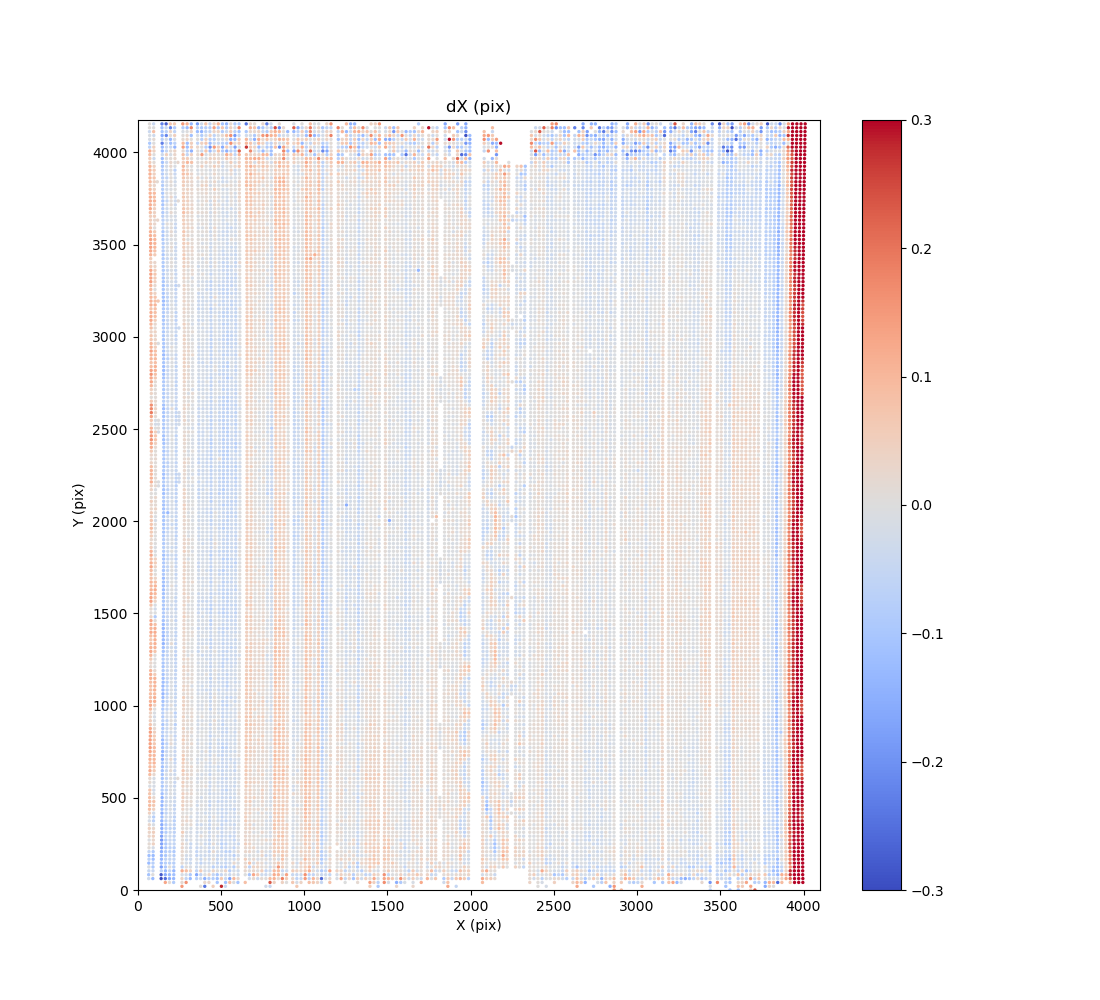

In [64]:
fig=2; plt.close(fig)
fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(1, 1, 1)
mappable = ax.scatter(xarray, yarray, s=2, c=dxarray, cmap="coolwarm", vmin=-0.3, vmax=0.3)
plt.title("dX (pix)")
plt.xlabel("X (pix)")
plt.ylabel("Y (pix)")
plt.xlim(0, calexp.getDimensions()[0])
plt.ylim(0, calexp.getDimensions()[1])
fig.colorbar(mappable, ax=ax)
plt.show()